# Different sampling
This experiment aims to ensure that we get all popular songs and a broad range of other songs.

In [10]:
import sys
import string
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import numpy as np
import pandas as pd

sys.path.append("../")
from src import spotify_api

In [20]:
# setup API
api = spotify_api.SpotifyAPI()
api.get_access_token()

# Let's query tracks by letters

In [32]:
letters = list(string.ascii_lowercase)
tracks = {}

for l in tqdm(letters):
    response = api.get_authenticated(f"https://api.spotify.com/v1/search?q={l}&limit=50&type=track&offset=")
    search = response.json()
    for track in search['tracks']['items']:
        tracks[track['id']] = {'id': track['id'], 'name': track['name'], 'popularity': track['popularity']}
    time.sleep(0.25)

100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


Let's see what we got

In [24]:
len(tracks)

941

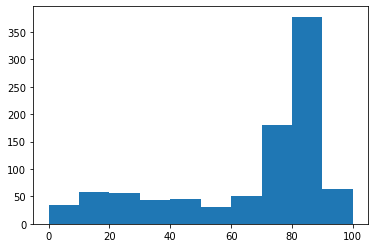

In [30]:
plt.hist([t["popularity"] for t in tracks.values()])
plt.show()

# Let's find a few more songs by browsing up to result page 10

In [37]:
letters = list(string.ascii_lowercase)
page = range(0, 10)
tracks = {}

for q, p in tqdm(list(itertools.product(letters, page))):
    offset = p * 50
    response = api.get_authenticated(f"https://api.spotify.com/v1/search?q={q}&limit=50&type=track&offset={offset}")
    search = response.json()
    for track in search['tracks']['items']:
        tracks[track['id']] = {'id': track['id'], 'name': track['name'], 'popularity': track['popularity']}
    time.sleep(0.25) # just do four requests per second to stay below quota

100%|██████████| 260/260 [02:33<00:00,  1.69it/s]


In [38]:
len(tracks)

5646

It looks like there are a lot of duplicates since we could have got `26*10*50=13000` songs.

Let's check the popularity distribution

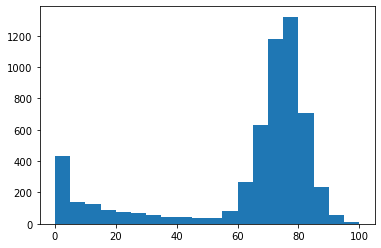

In [40]:
plt.hist([t["popularity"] for t in tracks.values()], bins=20)
plt.show()

That looks like a bimodal distribution with a normal distribution of the songs that are actually listened to and a second mode at 0 with songs that there never listened to.

Let's see what is the lowest popularity of Top10% most popular tracks

In [42]:
np.quantile([t["popularity"] for t in tracks.values()], .90)

82.0

## Sample with two letter combinations
We try to really get all popular songs and less never listened by giving more diverse search strings and only browse up to page 5 of results, so that we can have 27*26*5*50=175500 results in theory by making 3510 requests.

In [3]:
letters = list(string.ascii_lowercase)
page = range(0, 1)
tracks = {}
letter_combinations = letters + [c[0] + c[1] for c in list(itertools.product(letters, letters))]
for q, p in tqdm(list(itertools.product(letter_combinations, page))):
    offset = p * 50
    response = api.get_authenticated(f"https://api.spotify.com/v1/search?q={q}&limit=50&type=track&offset={offset}")
    search = response.json()
    for track in search['tracks']['items']:
        tracks[track['id']] = {'id': track['id'], 'name': track['name'], 'popularity': track['popularity']}
    time.sleep(0.25) # just do four requests per second to stay below quota

100%|██████████| 702/702 [08:59<00:00,  1.30it/s]


In [4]:
len(tracks)

28195

In [8]:
list(tracks.values())[:10]

[{'id': '4fouWK6XVHhzl78KzQ1UjL', 'name': 'abcdefu', 'popularity': 100},
 {'id': '52xJxFP6TqMuO4Yt0eOkMz',
  'name': "We Don't Talk About Bruno",
  'popularity': 94},
 {'id': '5enxwA8aAbwZbf5qCHORXi',
  'name': "All Too Well (10 Minute Version) (Taylor's Version) (From The Vault)",
  'popularity': 92},
 {'id': '4VXIryQMWpIdGgYR4TrjT1',
  'name': 'All Girls Are The Same',
  'popularity': 86},
 {'id': '1r9xUipOqoNwggBpENDsvJ',
  'name': 'Enemy (with JID) - from the series Arcane League of Legends',
  'popularity': 98},
 {'id': '1EQFOouqdKYdpbNoOHRVO2',
  'name': 'abcdefu (angrier)',
  'popularity': 84},
 {'id': '0bYg9bo50gSsH3LtXe2SQn',
  'name': 'All I Want for Christmas Is You',
  'popularity': 91},
 {'id': '07MDkzWARZaLEdKxo6yArG',
  'name': 'Meet Me At Our Spot',
  'popularity': 90},
 {'id': '2quVkyLSVr5wX2QIhnexUt', 'name': 'Already Dead', 'popularity': 85},
 {'id': '2Xr1dTzJee307rmrkt8c0g',
  'name': 'love nwantiti (ah ah ah)',
  'popularity': 93}]

Now let's get the audio features

In [21]:
num_tracks = len(tracks)
track_ids = list(tracks.keys())
api.get_access_token() # renew token
for i in tqdm(range(25000, num_tracks, 100)):
    batch_tracks = track_ids[i:min(i+100, num_tracks-1)]
    ids_list = ",".join(batch_tracks)

    response = api.get_authenticated(f"https://api.spotify.com/v1/audio-features?ids={ids_list}")
    for f in response.json()['audio_features']:
        if f is not None:
            tracks[f['id']]['danceability'] = f['danceability']
            tracks[f['id']]['energy'] = f['energy']
            tracks[f['id']]['liveness'] = f['liveness']
            tracks[f['id']]['loudness'] = f['loudness']
            tracks[f['id']]['speechiness'] = f['speechiness']
            tracks[f['id']]['acousticness'] = f['acousticness']
            tracks[f['id']]['instrumentalness'] = f['instrumentalness']
            tracks[f['id']]['tempo'] = f['tempo']
            tracks[f['id']]['valence'] = f['valence']
            tracks[f['id']]['key'] = f['key']
    time.sleep(0.25) # just do four requests per second to stay below quota

100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


Let's save them in our file

In [22]:
tracks_df = pd.DataFrame(tracks.values())
print(tracks_df.shape)
tracks_df.head()

(28195, 13)


,id,name,popularity,danceability,energy,liveness,loudness,speechiness,acousticness,instrumentalness,tempo,valence,key
0,4fouWK6XVHhzl78KzQ1UjL,abcdefu,100,0.695,0.540,0.3670,-5.692,0.0493,0.2990,0.000000,121.932,0.415,4.0
1,52xJxFP6TqMuO4Yt0eOkMz,We Don't Talk About Bruno,94,0.577,0.450,0.1110,-8.516,0.0834,0.3570,0.000000,205.863,0.830,0.0
2,5enxwA8aAbwZbf5qCHORXi,All Too Well (10 Minute Version) (Taylor's Ver...,92,0.631,0.518,0.0880,-8.771,0.0303,0.2740,0.000000,93.023,0.205,0.0
3,4VXIryQMWpIdGgYR4TrjT1,All Girls Are The Same,86,0.671,0.529,0.0856,-7.226,0.3070,0.0769,0.000335,161.989,0.203,0.0
4,1r9xUipOqoNwggBpENDsvJ,Enemy (with JID) - from the series Arcane Leag...,98,0.728,0.783,0.4340,-4.424,0.2660,0.2370,0.000000,77.011,0.555,11.0


In [23]:
tracks_df.isnull().sum(axis = 0)

id                   0
name                 0
popularity           0
danceability        43
energy              43
liveness            43
loudness            43
speechiness         43
acousticness        43
instrumentalness    43
tempo               43
valence             43
key                 43
dtype: int64

In [24]:
tracks_df.dropna()

,id,name,popularity,danceability,energy,liveness,loudness,speechiness,acousticness,instrumentalness,tempo,valence,key
0,4fouWK6XVHhzl78KzQ1UjL,abcdefu,100,0.695,0.5400,0.3670,-5.692,0.0493,0.299000,0.000000,121.932,0.415,4.0
1,52xJxFP6TqMuO4Yt0eOkMz,We Don't Talk About Bruno,94,0.577,0.4500,0.1110,-8.516,0.0834,0.357000,0.000000,205.863,0.830,0.0
2,5enxwA8aAbwZbf5qCHORXi,All Too Well (10 Minute Version) (Taylor's Ver...,92,0.631,0.5180,0.0880,-8.771,0.0303,0.274000,0.000000,93.023,0.205,0.0
3,4VXIryQMWpIdGgYR4TrjT1,All Girls Are The Same,86,0.671,0.5290,0.0856,-7.226,0.3070,0.076900,0.000335,161.989,0.203,0.0
4,1r9xUipOqoNwggBpENDsvJ,Enemy (with JID) - from the series Arcane Leag...,98,0.728,0.7830,0.4340,-4.424,0.2660,0.237000,0.000000,77.011,0.555,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28189,16jJcOTf3Ci89XXZjglOhp,Zz,1,0.614,0.8530,0.0632,-10.224,0.0300,0.000789,0.868000,129.985,0.929,3.0
28190,1JglVfTor06BLZvd5wl6Ym,ZzZz,42,0.642,0.6070,0.1790,-3.519,0.0547,0.240000,0.000000,76.961,0.410,4.0
28191,064ikblBFGS6HL35D71LZy,Mon amour,72,0.760,0.6160,0.1070,-8.557,0.0842,0.403000,0.000530,116.027,0.168,2.0
28192,5w8dmlHprwjUsrGuzTtOd8,ZZ,1,0.227,0.8800,0.1390,-8.624,0.0693,0.000007,0.810000,107.767,0.300,6.0


In [25]:
tracks_df.to_csv("../dat/tracks.csv")